# Binary classification risk control - Theoretical tests to validate implementation

# 1. The case of a random classifier

## 1.1. Protocol description
We test the theoretical guarantees of risk control in binary classification by using a random classifier and synthetic data. The aim is to evaluate the effectiveness of the BinaryClassificationController in maintaining a predefined risk level under different conditions.

Each test case looks at a combination of parameters, for which we repeat the experiment `n_repeat` times. The model is the same for all experiments (basically a random classifier), but the data is different each time.

Each experiment consists of the following:
 - We calibrate a BinaryClassificationController. It gives us the list of lambda values that control the risk according to LTT.
 - Because we know that the model is random, we know the theoretical risk associated with each lambda value. So we are able to check if the lambda values given by LTT actually control the risk. If not, we count 1 "error". Note that *each* lambda value should control the risk, not just one of them.

After n_repeat experiments, we compute the proportion of errors, that should be less than delta (1 - confidence_level).

## 1.2. Results
The risk is controlled in all the test cases. Overall, LTT seems very conservative (to achieve a high percentage of errors, we need to lower the confidence level significantly (0.01) and use only one threshold to avoid the Bonferroni effect). But this is likely due to the model being random, and thus having a lot of variance. It would be interesting to see how this evolves with a better model.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import make_classification
from sklearn.dummy import check_random_state
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings("ignore")

from mapie.risk_control import BinaryClassificationController, precision, accuracy, recall

In [3]:
# Using sklearn.dummy.DummyClassifier would be cleaner
class RandomClassifier:
    def __init__(self, seed=None, threshold=0.5):
        self.seed = seed
        self.threshold = threshold

    def _get_prob(self, x):
        local_seed = hash((x, self.seed)) % (2**32)
        rng = np.random.RandomState(local_seed)
        return np.round(rng.rand(), 2)

    def predict_proba(self, X):
        probs = np.array([self._get_prob(x) for x in X])
        return np.vstack([1 - probs, probs]).T

    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)


def precision_random_classifier(threshold: float) -> float:
    """
    Theoretical precision of RandomClassifier on a balanced dataset.
    - RandomClassifier assigns labels randomly with a uniform probability, independent of the true label.
    - Therefore, precision is always 0.5 regardless of the threshold.
    """
    return 0.5


def accuracy_random_classifier(threshold: float) -> float:
    """
    Theoretical accuracy of RandomClassifier on a balanced dataset.
    - RandomClassifier assigns labels randomly with a uniform probability, independent of the true label.
    - Therefore, accuracy is always 0.5 regardless of the threshold.
    """
    return 0.5


def recall_random_classifier(threshold: float) -> float:
    """
    Theoretical recall of RandomClassifier on a balanced dataset.
    - RandomClassifier assigns labels randomly with a uniform probability, independent of the true label.
    - Therefore, recall = 1 - threshold.
    """
    return 1.0 - threshold

In [4]:
def plot_metrics_vs_lambda(thresholds, metrics_funcs, metric_names, target_level, corner_width=0.05, fig_title=""):
    fig, axes = plt.subplots(1, len(metrics_funcs), figsize=(6*len(metrics_funcs), 5))

    if len(metrics_funcs) == 1:
        axes = [axes]

    for ax, func, name in zip(axes, metrics_funcs, metric_names):
        values = [func(t) for t in thresholds]
        ax.plot(thresholds, values, color="blue", label=name)

        ax.axhline(y=target_level, color="black", linestyle="--")
        ax.text(
            0.65, target_level + 0.02,
            f"Target {name.lower()} = {target_level}",
            color="tab:gray", fontstyle="italic"
        )

        ax.set_xlabel(r"$\lambda$")
        ax.set_ylabel(name)
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_title(f"{name}")
        ax.legend(loc="best", borderaxespad=1)

    fig.suptitle(fig_title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.tight_layout()
    plt.show()

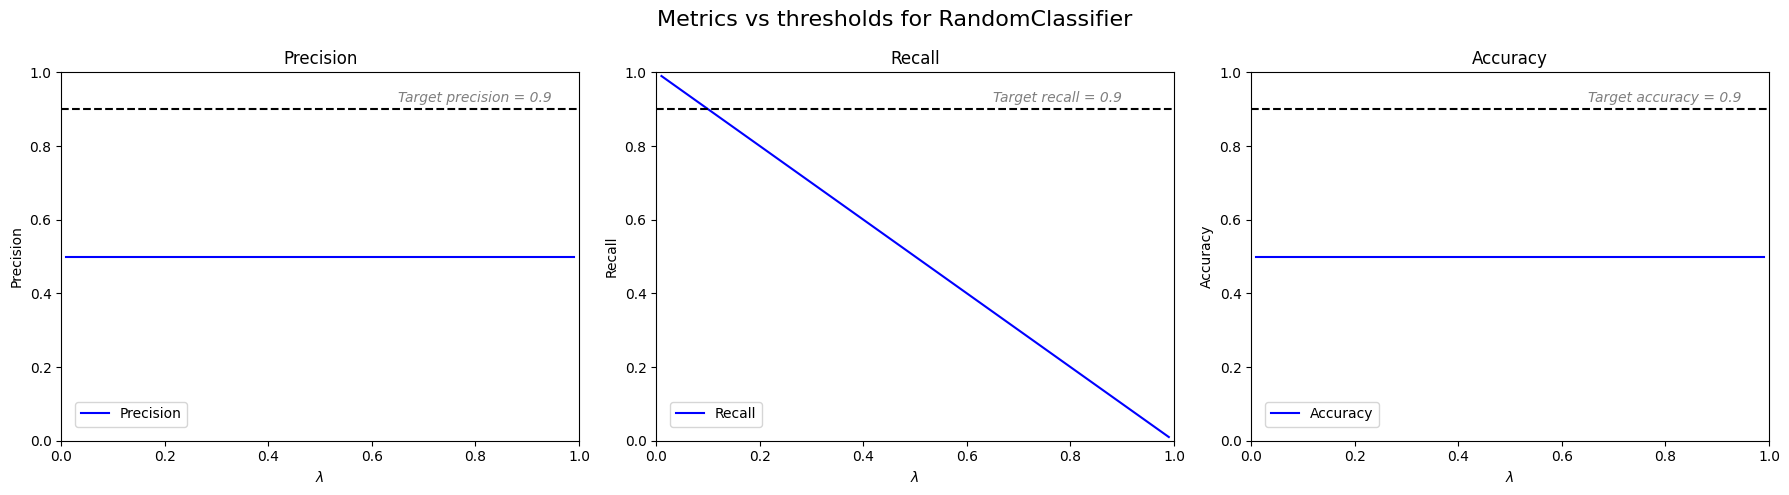

In [5]:
predict_params = np.linspace(0.01, 0.99, 100)
metrics_funcs = [
    precision_random_classifier,
    recall_random_classifier,
    accuracy_random_classifier
]
metric_names = ["Precision","Recall", "Accuracy"]
target_level = 0.9

plot_metrics_vs_lambda(predict_params, metrics_funcs, metric_names, target_level, corner_width=0.05, fig_title="Metrics vs thresholds for RandomClassifier")

**Controllability with Confidence Level**

A configuration is said to be **controllable at confidence level** $1-\delta$ if the following condition holds:

$$
\mathbb{P}\left( \sup_{\lambda} \, \text{Metric}(\lambda) > 1 - \alpha \right) \ge 1 - \delta
$$

where:
- $\lambda$ denotes the prediction parameter,
- $\text{Metric}(\lambda)$ is the metric of interest (precision, recall, or accuracy),
- $1-\alpha$ is the target level,
- $1-\delta$ is the confidence level.


In [6]:
# From the plots above, we can see which configurations can be controlled or not using RandomClassifier.
risk_name_list = [
    "precision", "precision", "precision", "precision",
    "recall", "recall", "recall", "recall",
    "accuracy", "accuracy", "accuracy", "accuracy"
]
target_level_list = [
    0.1, 0.1, 0.9, 0.9,
    0.1, 0.1, 0.9, 0.9,
    0.1, 0.1, 0.9, 0.9
]
confidence_level_list = [
    0.8, 0.2, 0.8, 0.2,
    0.8, 0.2, 0.8, 0.2,
    0.8, 0.2, 0.8, 0.2
]

# For predict_params = [np.linspace(0, 0.99, 100)]
can_be_controlled_vectors_predict_params_random_classifier = [
    True, True, False, False,
    True, True, True, True,
    True, True, False, False
]

# For predict_param_set = np.array([0.7])
can_be_controlled_single_predict_param_random_classifier = [
    True, True, False, False,
    True, True, False, False,
    True, True, False, False
]

df_validity_random_classifier = pd.DataFrame({
    "risk_name": risk_name_list,
    "target_level": target_level_list,
    "confidence_level": confidence_level_list,
    "is_controlable_exp": can_be_controlled_vectors_predict_params_random_classifier,
    "is_controlable_exp_single_param": can_be_controlled_single_predict_param_random_classifier
})

In [7]:
def run_one_experiment_with_random_classifier(clf_class, risk_dict, predict_params, target_level, confidence_level, N, n_repeats):
    """
    Runs the experiment for one combination of risk, predict_params, target_level, confidence_level.
    Returns a DataFrame with one row per repeat.
    """
    clf = clf_class()
    records = []

    for repeat_id in range(n_repeats):
        X_calibrate, y_calibrate = make_classification(
            n_samples=N,
            n_features=1,
            n_informative=1,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=1,
            weights=[0.5, 0.5],
            flip_y=0,
            random_state=None
        )
        X_calibrate = X_calibrate.squeeze()

        controller = BinaryClassificationController(
            predict_function=clf.predict_proba,
            risk=risk_dict["risk"],
            target_level=target_level,
            confidence_level=confidence_level,
            list_predict_params=predict_params
        )
        controller.calibrate(X_calibrate, y_calibrate)
        valid_parameters = controller.valid_predict_params

        error_indicator = 0

        if len(valid_parameters) == 0:
            error_indicator = 1
        else:
            for lambda_ in valid_parameters:
                if risk_dict["risk"] == precision:
                    theoretical_metric = precision_random_classifier(lambda_)
                elif risk_dict["risk"] == recall:
                    theoretical_metric = recall_random_classifier(lambda_)
                elif risk_dict["risk"] == accuracy:
                    theoretical_metric = accuracy_random_classifier(lambda_)

                if risk_dict["risk"].higher_is_better:
                    if theoretical_metric <= target_level:
                        error_indicator = 1
                        break
                else:
                    if theoretical_metric > target_level:
                        error_indicator = 1
                        break

        records.append({
            "risk_name": risk_dict["name"],
            "predict_param": predict_params,
            "target_level": target_level,
            "confidence_level": confidence_level,
            "repeat_id": repeat_id,
            "error_indicator": error_indicator,
            "valid_param": valid_parameters,
            "nb_valid_param": len(valid_parameters),
        })

    return pd.DataFrame(records)

In [8]:
def analyze_results(df_results):
    summary = []
    grouped = df_results.groupby(
        ["risk_name", "target_level", "confidence_level"]
    )

    for (risk_name, target_level, confidence_level), group in grouped:
        proportion_not_controlled = group["error_indicator"].mean()
        nb_predict_parameters = len(group.iloc[0]["predict_param"])
        mean_nb_valid_thresholds = group["nb_valid_param"].mean()

        delta = 1 - confidence_level
        valid_experiment = proportion_not_controlled <= delta

        summary.append({
            "risk_name": risk_name,
            "target_level": target_level,
            "confidence_level": confidence_level,
            "nb_predict_param": nb_predict_parameters,
            "prop_not_controlled": proportion_not_controlled,
            "delta": delta,
            "mean_nb_valid_thr": mean_nb_valid_thresholds,
            "empirical_control": valid_experiment
        })

    df_summary = pd.DataFrame(summary)

    return df_summary

In [9]:
N = 2000  # size of the calibration set
risk = [
    {"name": "precision", "risk": precision},
    {"name": "recall", "risk": recall},
    {"name": "accuracy", "risk": accuracy},
]
target_level = [0.1, 0.9]
confidence_level = [0.8, 0.2]
n_repeats = 100

print("#------------------Random classifier : the case of multiple parameters------------------#")
predict_params = [np.linspace(0.01, 0.99, 100)]
all_results = []

for combination in product(risk, predict_params, target_level, confidence_level):
    risk_dict, predict_param_set, t_level, c_level = combination

    df_one = run_one_experiment_with_random_classifier(
        clf_class=RandomClassifier,
        risk_dict=risk_dict,
        predict_params=predict_param_set,
        target_level=t_level,
        confidence_level=c_level,
        N=N,
        n_repeats=n_repeats
    )

    all_results.append(df_one)

df_results = pd.concat(all_results, ignore_index=True)
df_summary = analyze_results(df_results)
df_summary = df_summary.merge(
    df_validity_random_classifier.drop(columns=["is_controlable_exp_single_param"]),
    on=["risk_name", "target_level", "confidence_level"],
    how="inner",
)
display(df_summary)

print("#------------------Random classifier : the case of single parameter------------------#")
all_results_single_param = []

for combination in product(risk, target_level, confidence_level):
    risk_dict, t_level, c_level = combination

    predict_param_set = np.array([0.7])

    df_one = run_one_experiment_with_random_classifier(
        clf_class=RandomClassifier,
        risk_dict=risk_dict,
        predict_params=predict_param_set,
        target_level=t_level,
        confidence_level=c_level,
        N=N,
        n_repeats=n_repeats
    )

    all_results_single_param.append(df_one)

df_results_single_param = pd.concat(all_results_single_param, ignore_index=True)
df_summary_single_param = analyze_results(df_results_single_param)
df_summary_single_param = df_summary_single_param.merge(
    df_validity_random_classifier.drop(columns=["is_controlable_exp"]),
    on=["risk_name", "target_level", "confidence_level"],
    how="inner",
)
display(df_summary_single_param)

#------------------Random classifier : the case of multiple parameters------------------#


,risk_name,target_level,confidence_level,nb_predict_param,prop_not_controlled,delta,mean_nb_valid_thr,empirical_control,is_controlable_exp
0,accuracy,0.1,0.2,100,0.00,0.8,100.00,True,True
1,accuracy,0.1,0.8,100,0.00,0.2,100.00,True,True
2,accuracy,0.9,0.2,100,1.00,0.8,0.00,False,False
3,accuracy,0.9,0.8,100,1.00,0.2,0.00,False,False
4,precision,0.1,0.2,100,0.00,0.8,99.96,True,True
5,precision,0.1,0.8,100,0.00,0.2,100.00,True,True
6,precision,0.9,0.2,100,1.00,0.8,0.00,False,False
7,precision,0.9,0.8,100,1.00,0.2,0.00,False,False
8,recall,0.1,0.2,100,0.00,0.8,87.53,True,True
9,recall,0.1,0.8,100,0.00,0.2,87.11,True,True


#------------------Random classifier : the case of single parameter------------------#


,risk_name,target_level,confidence_level,nb_predict_param,prop_not_controlled,delta,mean_nb_valid_thr,empirical_control,is_controlable_exp_single_param
0,accuracy,0.1,0.2,1,0.0,0.8,1.0,True,True
1,accuracy,0.1,0.8,1,0.0,0.2,1.0,True,True
2,accuracy,0.9,0.2,1,1.0,0.8,0.0,False,False
3,accuracy,0.9,0.8,1,1.0,0.2,0.0,False,False
4,precision,0.1,0.2,1,0.0,0.8,1.0,True,True
5,precision,0.1,0.8,1,0.0,0.2,1.0,True,True
6,precision,0.9,0.2,1,1.0,0.8,0.0,False,False
7,precision,0.9,0.8,1,1.0,0.2,0.0,False,False
8,recall,0.1,0.2,1,0.0,0.8,1.0,True,True
9,recall,0.1,0.8,1,0.0,0.2,1.0,True,True


# 2. The case of a logistic classifier

## 2.1. Protocol description
We use the same protocol as described above, with the difference that we employ a logistic classifier and synthetic data generated from a logistic data generator.

## 2.2. Results
The risk is controlled in all test cases. Overall, LTT appears to be very conservative. It would be interesting to observe how this behavior evolves with a more accurate or complex model.

In [6]:
# Define a simple logistic classifier
class LogisticClassifier:
    """Deterministic sigmoid-based binary classifier."""

    def __init__(self, scale=2.0, threshold=0.5):
        self.scale = scale
        self.threshold = threshold
    
    def sigmoid(self, x):
        """Sigmoid function."""
        return 1 / (1 + np.exp(-self.scale * x))
    
    def _get_prob(self, x):
        """Probability of class 1 for input x."""
        return self.sigmoid(x)

    def predict_proba(self, X):
        """Return probabilities [p(y=0), p(y=1)] for each sample in X."""
        probs = np.array([self._get_prob(x) for x in X])
        return np.vstack([1 - probs, probs]).T

    def predict(self, X):
        """Return predicted class labels based on threshold."""
        probs = self.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

In [7]:
# Function to generate logistic data
def make_logistic_data(n_samples=200, scale=2.0, random_state=None):
    rng = check_random_state(random_state)
    X = rng.uniform(-3, 3, size=n_samples)
    probs = LogisticClassifier(scale=scale).sigmoid(X)
    y = rng.binomial(1, probs)
    return X, y


# Theoretical metrics for LogisticClassifier
def precision_logistic_classifier(scale: float, threshold: float) -> float:
    """
    Theoretical precision of LogisticClassifier based on the `make_logistic_data` generator.
    - Data are generated as pairs (X, Y), where
        - X ~ Uniform(-3, 3)
        - Y | X=x ~ Bernoulli(p(x))
        - p(x) = P(Y=1|X=x) = 1 / (1 + exp(-scale * x))
    - Precision has a closed-form expression depending on `scale` and `threshold`.
    """
    decision_threshold = np.log(threshold / (1 - threshold)) / scale
    TP = 1 / (6 * scale) * (np.log(1 + np.exp(3 * scale)) - np.log(1 + np.exp(scale * decision_threshold)))
    TP_plus_FP = (3 - decision_threshold) / 6

    return TP / TP_plus_FP


def accuracy_logistic_classifier(scale: float, threshold: float) -> float:
    """
    Theoretical accuracy of LogisticClassifier based on the `make_logistic_data` generator.
    - Data are generated as pairs (X, Y), where
        - X ~ Uniform(-3, 3)
        - Y | X=x ~ Bernoulli(p(x))
        - p(x) = P(Y=1|X=x) = 1 / (1 + exp(-scale * x))
    - Accuracy has a closed-form expression depending on `scale` and `threshold`.
    """
    decision_threshold = np.log(threshold / (1 - threshold)) / scale
    TP = 1 / (6 * scale) * (np.log(1 + np.exp(3 * scale)) - np.log(1 + np.exp(scale * decision_threshold)))
    FN = 1 / (6 * scale) * (np.log(1 + np.exp(scale * decision_threshold)) - np.log(1 + np.exp(-3 * scale)))
    FN_plus_TN = (3 + decision_threshold) / 6
    TN = FN_plus_TN - FN
    return TP + TN


def recall_logistic_classifier(scale: float, threshold: float) -> float:
    """
    Theoretical recall of LogisticClassifier based on the `make_logistic_data` generator.
    - Data are generated as pairs (X, Y), where
        - X ~ Uniform(-3, 3)
        - Y | X=x ~ Bernoulli(p(x))
        - p(x) = P(Y=1|X=x) = 1 / (1 + exp(-scale * x))
    - Recall has a closed-form expression depending on `scale` and `threshold`.
    """
    decision_threshold = np.log(threshold / (1 - threshold)) / scale
    TP = 1 / (6 * scale) * (np.log(1 + np.exp(3 * scale)) - np.log(1 + np.exp(scale * decision_threshold)))
    FN = 1 / (6 * scale) * (np.log(1 + np.exp(scale * decision_threshold)) - np.log(1 + np.exp(-3 * scale)))
    return TP / (TP + FN)

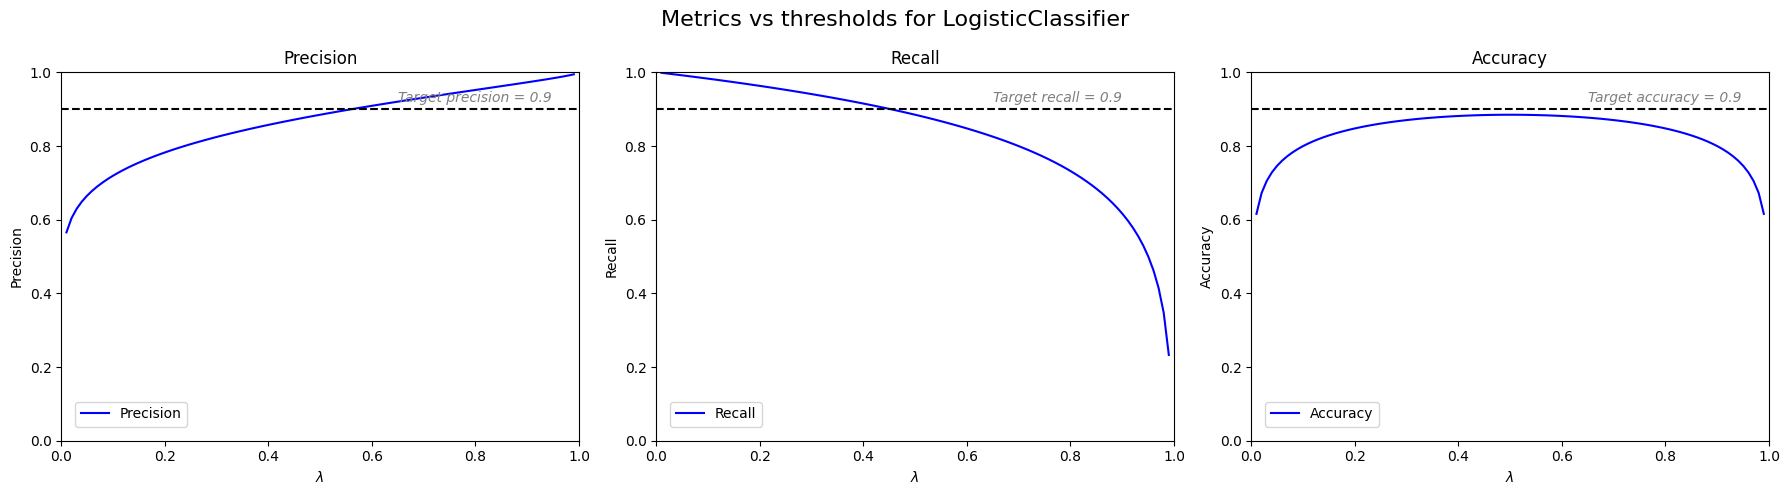

In [8]:
predict_params = np.linspace(0.01, 0.99, 100)
scale = 2.0
metrics_funcs = [
    (lambda t, s=scale: precision_logistic_classifier(s, t)),
    (lambda t, s=scale: recall_logistic_classifier(s, t)),
    (lambda t, s=scale: accuracy_logistic_classifier(s, t))
]
metric_names = ["Precision","Recall", "Accuracy"]
target_level = 0.9

plot_metrics_vs_lambda(predict_params, metrics_funcs, metric_names, target_level, corner_width=0.05, fig_title="Metrics vs thresholds for LogisticClassifier")

In [13]:
# From the plots above, we can see which configurations can be controlled or not using LogisticClassifier.
risk_name_list = [
    "precision", "precision", "precision", "precision",
    "recall", "recall", "recall", "recall",
    "accuracy", "accuracy", "accuracy", "accuracy"
]
target_level_list = [
    0.1, 0.1, 0.9, 0.9,
    0.1, 0.1, 0.9, 0.9,
    0.1, 0.1, 0.9, 0.9
]
confidence_level_list = [
    0.8, 0.2, 0.8, 0.2,
    0.8, 0.2, 0.8, 0.2,
    0.8, 0.2, 0.8, 0.2
]

# For predict_params = [np.linspace(0, 0.99, 100)]
can_be_controlled_vectors_predict_params_logistic_classifier = [
    True, True, True, True,
    True, True, True, True,
    True, True, False, False
]

# For predict_param_set = np.array([0.7])
can_be_controlled_single_predict_param_logistic_classifier = [
    True, True, True, True,
    True, True, False, False,
    True, True, False, False
]

df_validity_logistic_classifier = pd.DataFrame({
    "risk_name": risk_name_list,
    "target_level": target_level_list,
    "confidence_level": confidence_level_list,
    "is_controlable_exp": can_be_controlled_vectors_predict_params_logistic_classifier,
    "is_controlable_exp_single_param": can_be_controlled_single_predict_param_logistic_classifier
})

In [14]:
X, y = make_logistic_data(n_samples=300, scale=2.0, random_state=None)

x_curve = np.linspace(-3, 3, 400)
sigmoid_model = LogisticClassifier(scale=2.0)
y_curve = sigmoid_model.sigmoid(x_curve)

X_class_0 = X[y == 0]
X_class_1 = X[y == 1]
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=X_class_0,
    y=np.zeros_like(X_class_0),
    mode="markers",
    name='"negative" class',
    marker=dict(size=8),
))
fig.add_trace(go.Scatter(
    x=X_class_1,
    y=np.ones_like(X_class_1),
    mode="markers",
    name='"positive" class',
    marker=dict(size=8),
))

fig.add_trace(go.Scatter(
    x=x_curve,
    y=y_curve,
    mode="lines",
    name="Sigmoid",
    line=dict(width=3)
))
fig.update_layout(
    title="Logistic generated data and the sigmoid probability function",
    xaxis_title="X",
    yaxis_title="Probability and class labels",
    yaxis=dict(range=[-0.1, 1.1]),
    legend=dict(x=0.02, y=0.98),
    width=800,
    height=500
)
fig.show()


In [15]:
def run_one_experiment_with_logistic_classifier(
        clf_class, risk_dict, predict_params, target_level, confidence_level, N, n_repeats, scale=2.0
    ):
    """
    Runs the experiment for one combination of using a LogisticClassifier.

    Returns a DataFrame with one row per repeat.
    """
    clf = clf_class(scale=scale, threshold=0.5)
    records = []

    for repeat_id in range(n_repeats):
        X_calibrate, y_calibrate = make_logistic_data(n_samples=N, scale=scale, random_state=None)

        controller = BinaryClassificationController(
            predict_function=clf.predict_proba,
            risk=risk_dict["risk"],
            target_level=target_level,
            confidence_level=confidence_level,
            list_predict_params=predict_params,
        )
        controller = controller.calibrate(X_calibrate, y_calibrate)
        valid_parameters = controller.valid_predict_params

        error_indicator = 0

        if len(valid_parameters) == 0:
            error_indicator = 1
        else:
            for lambda_ in valid_parameters:
                if risk_dict["risk"] == precision:
                    empirical_metric = precision_logistic_classifier(scale, lambda_)
                elif risk_dict["risk"] == recall:
                    empirical_metric = recall_logistic_classifier(scale, lambda_)
                elif risk_dict["risk"] == accuracy:
                    empirical_metric = accuracy_logistic_classifier(scale, lambda_)

                if risk_dict["risk"].higher_is_better:
                    if empirical_metric <= target_level:
                        error_indicator = 1
                        break
                else:
                    if empirical_metric > target_level:
                        error_indicator = 1
                        break

        records.append({
            "risk_name": risk_dict["name"],
            "predict_param": predict_params,
            "target_level": target_level,
            "confidence_level": confidence_level,
            "repeat_id": repeat_id,
            "error_indicator": error_indicator,
            "valid_param": valid_parameters,
            "nb_valid_param": len(valid_parameters),
        })

    return pd.DataFrame(records)

In [16]:
N = 2000
risk = [
    {"name": "precision", "risk": precision},
    {"name": "recall", "risk": recall},
    {"name": "accuracy", "risk": accuracy},
]
target_level = [0.1, 0.9]
confidence_level = [0.8, 0.2]
n_repeats = 100
scale = 2.0

print("#------------------Logistic classifier : the case of multiple parameters------------------#")

predict_params = [np.linspace(0.01, 0.99, 100)]
all_results = []

for combination in product(risk, predict_params, target_level, confidence_level):
    risk_dict, predict_param_set, t_level, c_level = combination

    df_one = run_one_experiment_with_logistic_classifier(
        clf_class=LogisticClassifier,
        risk_dict=risk_dict,
        predict_params=predict_param_set,
        target_level=t_level,
        confidence_level=c_level,
        N=N,
        n_repeats=n_repeats,
        scale=scale
    )

    all_results.append(df_one)

df_results= pd.concat(all_results, ignore_index=True)
df_summary = analyze_results(df_results)
df_summary = df_summary.merge(
    df_validity_logistic_classifier.drop(columns=["is_controlable_exp_single_param"]),
    on=["risk_name", "target_level", "confidence_level"],
    how="inner",
)
display(df_summary)

print("#------------------Logistic classifier : the case of single parameter------------------#")

all_results_single_param = []

for combination in product(risk, target_level, confidence_level):
    risk_dict, t_level, c_level = combination

    predict_param_set = np.array([0.7])

    df_one = run_one_experiment_with_logistic_classifier(
        clf_class=LogisticClassifier,
        risk_dict=risk_dict,
        predict_params=predict_param_set,
        target_level=t_level,
        confidence_level=c_level,
        N=N,
        n_repeats=n_repeats,
        scale=scale
    )

    all_results_single_param.append(df_one)

df_results_single_param = pd.concat(all_results_single_param, ignore_index=True)
df_summary_single_param = analyze_results(df_results_single_param)
df_summary_single_param = df_summary_single_param.merge(
    df_validity_logistic_classifier.drop(columns=["is_controlable_exp"]),
    on=["risk_name", "target_level", "confidence_level"],
    how="inner",
)
display(df_summary_single_param)

#------------------Logistic classifier : the case of multiple parameters------------------#


,risk_name,target_level,confidence_level,nb_predict_param,prop_not_controlled,delta,mean_nb_valid_thr,empirical_control,is_controlable_exp
0,accuracy,0.1,0.2,100,0.0,0.8,100.00,True,True
1,accuracy,0.1,0.8,100,0.0,0.2,100.00,True,True
2,accuracy,0.9,0.2,100,1.0,0.8,0.00,False,False
3,accuracy,0.9,0.8,100,1.0,0.2,0.00,False,False
4,precision,0.1,0.2,100,0.0,0.8,100.00,True,True
5,precision,0.1,0.8,100,0.0,0.2,100.00,True,True
6,precision,0.9,0.2,100,0.0,0.8,32.56,True,True
7,precision,0.9,0.8,100,0.0,0.2,30.27,True,True
8,recall,0.1,0.2,100,0.0,0.8,100.00,True,True
9,recall,0.1,0.8,100,0.0,0.2,100.00,True,True


#------------------Logistic classifier : the case of single parameter------------------#


,risk_name,target_level,confidence_level,nb_predict_param,prop_not_controlled,delta,mean_nb_valid_thr,empirical_control,is_controlable_exp_single_param
0,accuracy,0.1,0.2,1,0.00,0.8,1.00,True,True
1,accuracy,0.1,0.8,1,0.00,0.2,1.00,True,True
2,accuracy,0.9,0.2,1,1.00,0.8,0.00,False,False
3,accuracy,0.9,0.8,1,1.00,0.2,0.00,False,False
4,precision,0.1,0.2,1,0.00,0.8,1.00,True,True
5,precision,0.1,0.8,1,0.00,0.2,1.00,True,True
6,precision,0.9,0.2,1,0.00,0.8,1.00,True,True
7,precision,0.9,0.8,1,0.02,0.2,0.98,True,True
8,recall,0.1,0.2,1,0.00,0.8,1.00,True,True
9,recall,0.1,0.8,1,0.00,0.2,1.00,True,True
